In [9]:
%matplotlib inline
import sys
sys.path.append("..")

# DeepTrack - Characterizing aberrations

This notebook demonstrates how to characterize the aberrations in an optical device using an image of particle. We will specifically look at spherical aberration, though the example can be extended to other aberrations.

It is recommended to read both [deeptrack_introdution_tutorial](./deeptrack_introdution_tutorial.ipynb) and [tracking_particle_cnn_tutorial](./tracking_particle_cnn_tutorial.ipynb) before reading this tutorial.

## 1. Setup

Imports needed for this tutorial.

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from deeptrack.scatterers import Ellipse
from deeptrack.optics import Fluorescence
from deeptrack.noises import Poisson, Offset
from deeptrack.aberrations import SphericalAberration
from deeptrack.math import NormalizeMinMax

from deeptrack.models import convolutional
from deeptrack.generators import Generator

## 2. Defining the features

We define the features needed for this example. 

* optics - Flourescence microscope with a pixel size of 0.1 microns and a 128x128 camera
* particle - Spherical particle roughly centered in the image, a micron out of focus
* aberration - Spherical aberration with a coefficient between -4 and 4
* noise - A constant background illumantion and a Poisson noise with SNR 100
* normalization - Maps the image to values between 0 and 1.

SphericalAberration is a wrapper of the more general Zernike feature, which introduces a phase to the pupil function based on the normalized Zernike polynomials. The property coefficient is a multiplier for the respective poynomial in the set of Zernike polynomials.

In [19]:
optics = Fluorescence(
    magnification=10,
    resolution=1e-6,
    wavelength=633e-9,
    output_region=(0, 0, 128, 128)
)

particle = Ellipse(
    position=lambda: np.random.randn(3) * (1, 1, 3) + (64, 64, 10),
    position_unit="pixel",
    intensity=10,
    radius=np.random.rand() * 1e-6 + 0.5e-6
)

aberration = SphericalAberration(coefficient=lambda: (2 * np.random.rand() - 1) * 4)

noise = Offset(offset=0.01) + Poisson(snr=100)

normalization = NormalizeMinMax(min=0, max=1)

## 3. Combining the features

To view the particle throught the aberrated microscope, we call `optics` with both the particle and the aberration. Then we add the noise and normalization as usual.

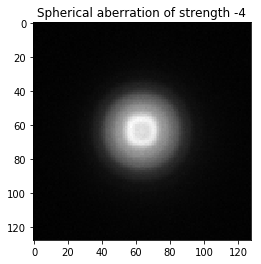

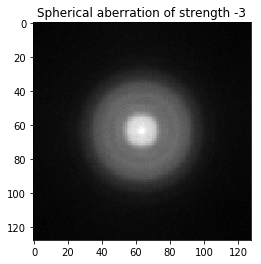

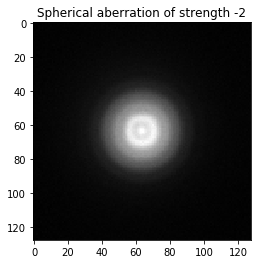

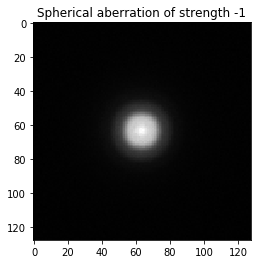

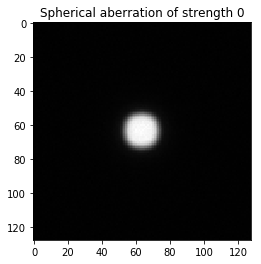

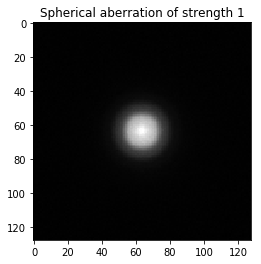

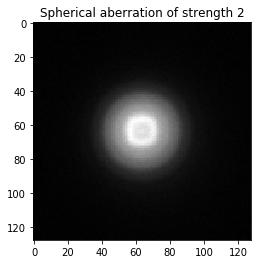

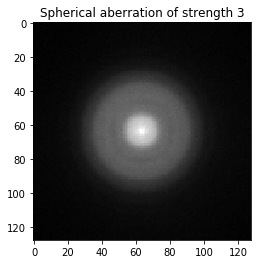

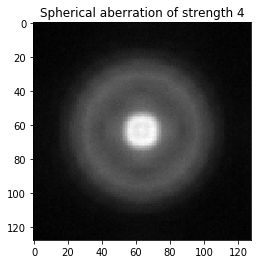

In [27]:
aberrated_particle = optics(particle, aberration) + noise + normalization

for coefficient in range(-4, 5):
    aberration.properties["coefficient"].current_value = coefficient
    
    plt.title("Spherical aberration of strength {0}".format(coefficient))
    aberrated_particle.plot(cmap="gray")
    

## 4. Defining the label function and the generator

We define a label function that iterates through all the properties and returns the coefficient of the SphericalAberration.

In [0]:
def get_aberration(image):
    for prop in image.properties:
        if prop["name"] == "SphericalAberration":
            return prop["coefficient"]

generator = Generator().generate(
    aberrated_particle, 
    get_aberration, 
    batch_size=32
)

## 5. Creating the model

We will use a standard convolution model for this task. Since this is a regression task, we will use mean absolute error as loss.

In [0]:
model = convolutional(
    input_shape=(128, 128, 1), 
    number_of_outputs=1
)

model.compile(
    optimizer='rmsprop', 
    loss='mae', 
    metrics=['mse', 'mae']
)

## 6. Training the model

We train the model for 100 epochs.

In [0]:
model.fit(
    generator, 
    epochs=100, 
    steps_per_epoch=20
)

## Validating the result

Finally we validate the result by plotting the predicted value against the true value.

In [0]:
batch, labels = next(generator)

prediction = model.predict(batch)

plt.scatter(labels, prediction)
plt.plot([-5, 5], [-5, 5])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("Ground truth")
plt.ylabel("Predicted value")
plt.title("Spherical aberration coefficient")  